# Load libraries

In [1]:
import pickle, logging
import tensorflow as tf
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense,SimpleRNN, GRU
from tensorflow.keras.preprocessing.text import Tokenizer
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve,auc
import matplotlib.pyplot as plt

In [35]:
tf.__version__

'2.0.1'

# Load data

In [2]:
reviews=pd.read_csv('../data/amazon_reviews_us_Apparel_v1_00.tsv.gz.tsv',sep='\t')

In [3]:
reviews['label']=(reviews['verified_purchase']=='y').astype(int)

In [4]:
reviews=reviews.dropna()

In [5]:
reviews['label'].mean()

0.8995045187685107

# Re-samples

In [6]:
def get_samples(df, n):
    samples=df[:n]
    print('Initial label mean: {0}'.format(samples['label'].mean()))
    counts=samples.groupby('label')['label'].count().to_dict()
    sorted_counts = sorted(counts.items(), key=lambda kv: kv[1])
    undersample = samples[samples['label'] == sorted_counts[1][0]].sample(sorted_counts[0][1])
    samples=pd.concat([undersample, samples[samples['label'] == sorted_counts[0][0]]])
    print('Undersampled label mean: {0}'.format(samples['label'].mean()))
    return samples

In [7]:
def clean_text(df,features=['review_body','label']):
    df['review_body'].replace(regex=[r'([^a-z\s]+)'], value='', inplace=True)
    return df[features].copy()

In [8]:
samples=get_samples(reviews, n=5000)
samples=clean_text(samples)

Initial label mean: 0.6492
Undersampled label mean: 0.5


In [9]:
samples['review_body'].head()

3646                                    very cute pajamas
580     im  and im around  but i got a large and a med...
4084    love this toplove hue sleepwear always washes ...
3572                                        it s allright
3151                                            excelleny
Name: review_body, dtype: object

## Save/Load the clean dataframe

In [32]:
# size=len(reviews)
# samples=get_samples(reviews, n=size)
# samples=clean_text(samples)
# saved_dataframe='results/clean_data_frame.p'
# pickle.dump( samples, open( saved_dataframe, "wb" ) )
# samples= pickle.load( open( saved_dataframe, "rb" ) )

Initial label mean: 0.8995045187685107
Undersampled label mean: 0.5


# Split data

In [11]:
def split_pad(selected_reviews):
    X_train, X_test, Y_train, Y_test = train_test_split(selected_reviews['review_body'].values,\
                                                    selected_reviews['label'].values,\
                                                    test_size=0.10,\
                                                    shuffle=True)
    for label in [Y_train, Y_test]:
          logging.debug("label mean: {0}".format(label.mean()))
    tokenizer = Tokenizer(num_words= 50000)
    tokenizer.fit_on_texts(X_train)
    X_train_tok = tokenizer.texts_to_sequences(X_train)
    X_test_tok = tokenizer.texts_to_sequences(X_test)
    max_review_length = 600
    X_train_pad = sequence.pad_sequences(X_train_tok, maxlen=max_review_length)
    X_test_pad = sequence.pad_sequences(X_test_tok, maxlen=max_review_length)
    return X_train_pad, X_test_pad, Y_train, Y_test

# Compile models

In [12]:
models=[]

max_review_length = 600
embedding_vector_length = 32
top_words = 50000
models.append(Sequential())
model=models[-1]
model.add(Embedding(top_words, embedding_vector_length, input_length=max_review_length))
# The output of SimpleRNN will be a 2D tensor of shape (batch_size, 128)
model.add(SimpleRNN(128))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy',tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

In [13]:
embedding_vector_length = 40
models.append(Sequential())
model=models[-1]
model.add(Embedding(top_words+1, embedding_vector_length, input_length=max_review_length))
model.add(LSTM(32,return_sequences=True))
model.add(LSTM(16))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy',tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

In [14]:
models.append(Sequential())
model=models[-1]
model.add(Embedding(top_words, embedding_vector_length, input_length=max_review_length))
# The output of GRU will be a 3D tensor of shape (batch_size, timesteps, 256)
model.add(GRU(256, return_sequences=True))
model.add(SimpleRNN(128))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy',tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

In [15]:
st = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
tb=tf.keras.callbacks.TensorBoard(log_dir='logs')

In [16]:
!rm -rf logs

In [17]:
X_train_pad, X_test_pad, Y_train, Y_test=split_pad(samples)
for model in models:
    model.fit(X_train_pad, Y_train, epochs=100, callbacks=[st], batch_size=64,validation_data=(X_test_pad,Y_test))
    # Final evaluation of the model on test data
    scores = model.evaluate(X_test_pad, Y_test, verbose=0)
    print("loss: {0:2.2f}, accuracy {1:2.2f}".format(scores[0],scores[1]))

Train on 3157 samples, validate on 351 samples
Epoch 1/100
3157/3157 [==============================] - 15s 5ms/sample - loss: 0.6811 - accuracy: 0.5613 - recall: 0.5673 - precision: 0.5620 - val_loss: 0.6523 - val_accuracy: 0.6011 - val_recall: 0.9649 - val_precision: 0.5518
Epoch 2/100
3157/3157 [==============================] - 13s 4ms/sample - loss: 0.5917 - accuracy: 0.6988 - recall: 0.7543 - precision: 0.6800 - val_loss: 0.6114 - val_accuracy: 0.6296 - val_recall: 0.7778 - val_precision: 0.5911
Epoch 3/100
3157/3157 [==============================] - 12s 4ms/sample - loss: 0.5489 - accuracy: 0.7517 - recall: 0.8484 - precision: 0.7117 - val_loss: 0.6069 - val_accuracy: 0.6610 - val_recall: 0.8304 - val_precision: 0.6121
Epoch 4/100
3157/3157 [==============================] - 13s 4ms/sample - loss: 0.5430 - accuracy: 0.7491 - recall: 0.7915 - precision: 0.7306 - val_loss: 0.6206 - val_accuracy: 0.6410 - val_recall: 0.9123 - val_precision: 0.5843
Epoch 5/100
3157/3157 [==========

In [18]:
def get_roc(model):
    y_pred_keras = model.predict(X_test_pad).ravel()
    fpr_keras, tpr_keras, thresholds_keras = roc_curve(Y_test, y_pred_keras)
    auc_keras = auc(fpr_keras, tpr_keras)
    return fpr_keras, tpr_keras, auc_keras

In [21]:
names=['Simple RNN','LSTM','GRU']

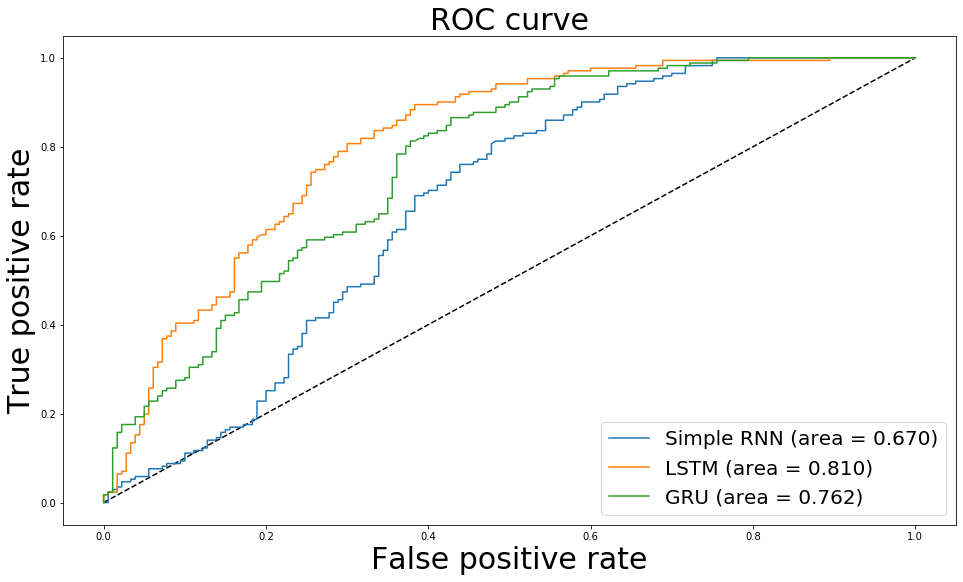

In [40]:
plt.figure(1,figsize=(16,9))
plt.plot([0, 1], [0, 1], 'k--')
for i,model in enumerate(models):
    fpr_keras, tpr_keras, auc_keras=get_roc(model)
    plt.plot(fpr_keras, tpr_keras, label='{0} (area = {1:.3f})'.format(names[i],auc_keras))
plt.xlabel('False positive rate', fontsize= 30)
plt.ylabel('True positive rate', fontsize= 30)
plt.title('ROC curve', fontsize= 30)
plt.legend(loc='best', fontsize= 20)
plt.savefig('results/roc.png')
plt.show()